In [1]:
import openmc
import matplotlib.pyplot as plt
import numpy as np
import openmc_source_plotter
import neutronics_material_maker as nmm
import openmc_source_plotter

In [2]:


#Lupin materials

#lead casing
lead = openmc.Material(name='lead')
lead.add_element('Pb', 1, 'ao')
lead.set_density('g/cm3', 11.34)
#aluminium shell
al = openmc.Material(name='aluminium')
al.add_element('Al', 1, 'ao')
al.set_density('g/cm3', 2.7)
al.add_s_alpha_beta("c_Al27")
#cadmium
cadmium = openmc.Material(name='cadmium')
cadmium.add_element('Cd', 1, 'ao')
cadmium.set_density('g/cm3', 4.047)
#BF3
bf3 = nmm.Material.from_library('Boron Fluoride (BF3)', temperature=294, pressure=26664).openmc_material
#bf3.set_density("atom/b-cm",7.3e-4)
#polyethylene
polyethylene = openmc.Material(name='polyethylene')
polyethylene.add_elements_from_formula('C2H4')
polyethylene.set_density('g/cm3',0.93)
polyethylene.add_s_alpha_beta('c_H_in_CH2')


materials = openmc.Materials([lead, al, cadmium, bf3, polyethylene])
materials.export_to_xml()



In [3]:
#geometry dimensions
cylinder_radius = 5.4
detector_radius = 2
active_radius = 2.54/2
outer_cylinder_radius = 12.5
lead_thickness = 0.15
shielding_thickness = 0.15

lead_height = 14.1
b_detector_height = 4.7
active_detector_height = 15
cylinder_height = 29.7
big_cd_height = 5

small_cd_height = 2.5

cd_thickness = 0.15
cd_gap = 2.425

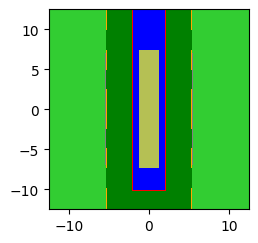

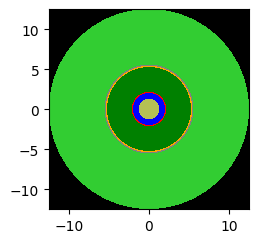

In [4]:
#geometry model

detector = openmc.ZCylinder(r=detector_radius)
active_detector = openmc.ZCylinder(r=active_radius)
shielding = openmc.ZCylinder(r=detector_radius + shielding_thickness)
inner_cylinder = openmc.ZCylinder(r=cylinder_radius)
lead_plate = openmc.ZCylinder(r=cylinder_radius + lead_thickness)
cd_cylinder = openmc.ZCylinder(r=cylinder_radius - (cd_thickness))
outer_cylinder = openmc.ZCylinder(r=outer_cylinder_radius)
source_sphere = openmc.Sphere(r=50)
outer_void = openmc.Sphere(r=55, boundary_type='vacuum')

top_cylinder = openmc.ZPlane(z0=0.5*cylinder_height)
bottom_cylinder = openmc.ZPlane(z0=-0.5*cylinder_height)
bottom_detector = openmc.ZPlane(z0=-0.5*cylinder_height + b_detector_height)
bottom_shielding = openmc.ZPlane(z0=-0.5*cylinder_height + b_detector_height-shielding_thickness)
top_lead = openmc.ZPlane(z0=0.5*lead_height)
bottom_lead = openmc.ZPlane(z0=-0.5*lead_height)
top_wall_cylinder = openmc.ZPlane(z0=0.5*cylinder_height+0.1)

top_active_detector = openmc.ZPlane(z0=0.5*(cylinder_height-active_detector_height))
bottom_active_detector = openmc.ZPlane(z0=0.5*(-cylinder_height+active_detector_height))

cd_cylinder_region = +cd_cylinder & -inner_cylinder 
cd_bottom_1 = openmc.ZPlane(0.5*cylinder_height-big_cd_height)
cd_top_2 = openmc.ZPlane(0.5*cylinder_height-big_cd_height-cd_gap)
cd_bottom_2 = openmc.ZPlane(0.5*cylinder_height-big_cd_height-cd_gap-small_cd_height)
cd_top_3 = openmc.ZPlane(0.5*cylinder_height-big_cd_height-cd_gap-small_cd_height-cd_gap)
cd_bottom_3 = openmc.ZPlane(0.5*cylinder_height-big_cd_height-cd_gap-small_cd_height-cd_gap-big_cd_height)
cd_top_4 = openmc.ZPlane(0.5*-cylinder_height+big_cd_height+cd_gap+small_cd_height)
cd_bottom_4 = openmc.ZPlane(0.5*-cylinder_height+big_cd_height+cd_gap)
cd_top_5 = openmc.ZPlane(0.5*-cylinder_height+big_cd_height)

cd_1 = cd_cylinder_region & -top_cylinder & +cd_bottom_1
cd_2 = cd_cylinder_region & -cd_top_2 & +cd_bottom_2
cd_3 = cd_cylinder_region & -cd_top_3 & +cd_bottom_3
cd_4 = cd_cylinder_region & -cd_top_4 & +cd_bottom_4
cd_5 = cd_cylinder_region & -cd_top_5 & +bottom_cylinder
cd_region = cd_1 | cd_2 | cd_3 | cd_4 | cd_5

active_detector_region = -active_detector & -top_active_detector & +bottom_active_detector
detector_region = -detector & -top_cylinder & +bottom_detector & ~active_detector_region
shielding_region = (-shielding & -top_cylinder & +bottom_shielding & +detector) | ( -detector & +bottom_shielding & -bottom_detector)

inner_polyethylene_region = ((-inner_cylinder & + shielding & -top_cylinder & +bottom_cylinder) | (-shielding & -bottom_shielding & +bottom_cylinder)) & ~cd_region

lead_region = -lead_plate & -top_lead & +bottom_lead & + inner_cylinder
outer_polyethylene_region = (-outer_cylinder & -top_cylinder & +bottom_cylinder & ~lead_region & +inner_cylinder ) | (-top_wall_cylinder & +top_cylinder & - outer_cylinder)
sphere_region = (-source_sphere & +outer_cylinder) | (+top_wall_cylinder & -source_sphere) | (-bottom_cylinder & -source_sphere)
outer_void_region = +source_sphere & -outer_void

active_detector_cell = openmc.Cell(region=active_detector_region, fill=bf3)
detector_cell = openmc.Cell(region=detector_region, fill=bf3)
shielding_cell = openmc.Cell(region=shielding_region, fill=al)
inner_polyethylene_cell = openmc.Cell(region=inner_polyethylene_region, fill=polyethylene)
lead_cell = openmc.Cell(region=lead_region, fill=lead)
cd_cell = openmc.Cell(region =cd_region, fill = cadmium)
outer_polyethylene_cell = openmc.Cell(region=outer_polyethylene_region, fill=polyethylene)
source_cell = openmc.Cell(region=sphere_region)
outer_void_cell = openmc.Cell(region=outer_void_region)

universe = openmc.universe = openmc.Universe(cells=[active_detector_cell, detector_cell, shielding_cell, inner_polyethylene_cell, lead_cell, cd_cell, outer_polyethylene_cell, source_cell, outer_void_cell])


x,y = 25,25
color_assignment = {detector_cell : 'blue',
                    shielding_cell : 'red',
                    inner_polyethylene_cell : 'green',
                    cd_cell : 'orange',
                    lead_cell : 'grey',
                    outer_polyethylene_cell :'limegreen',
                   source_cell : 'black'}
plt.show(universe.plot(width=(x, y), basis='xz',  colors=color_assignment))
plt.show(universe.plot(width=(x, y), basis='xy',  colors=color_assignment))
#plt.show(universe.plot(width=(x, y), basis='yz',  colors=color_assignment))

geometry = openmc.Geometry(universe)
geometry.export_to_xml()

In [9]:
from math import pi, cos
#now create the source
#spherical source enclosing the detector
def sett_func(source_energy):
    
    sett = openmc.Settings()
    sett.particles = 500000
    sett.batches = 3
    sett.inactive = 0
    sett.run_mode = 'fixed source'

    sphere_source = openmc.Source()

    sphere_source.particle = 'neutron'
    sphere_source.energy = openmc.stats.Discrete([source_energy],[1])
    #conical source
    aperture = np.degrees(np.arctan((cylinder_height/2)/50))
    
    print(aperture)
    mu = openmc.stats.Uniform(cos(aperture/2), 1.0)
    phi = openmc.stats.Uniform(0.0, 2*pi)
    angle = openmc.stats.PolarAzimuthal(mu, phi, reference_uvw=(-1, 0., 0.))
    sphere_source.angle = angle
    sphere_source.space = openmc.stats.Point((50,0,0))
    sett.source = sphere_source
    return sett
s = sett_func(14e6)

16.541419512846616


In [10]:
#now create a tally to calibrate the detector
def tallies_func(energy_bins):
    tallies = openmc.Tallies()
    neutron_particle_filter = openmc.ParticleFilter(['neutron'])
    energy_filter = openmc.EnergyFilter(energy_bins)
    detector_cell_filter = openmc.CellFilter(active_detector_cell)
    detector_tally = openmc.Tally(name='detector_tally')
    detector_tally.scores = ['flux']
    detector_tally.filters = [detector_cell_filter, neutron_particle_filter, energy_filter]
    tallies.append(detector_tally)

    #inelastic (n,alpha) reaction between neutrons and 10B
    detector_n_alpha_tally = openmc.Tally(name='detector_n_alpha_tally')
    detector_n_alpha_tally.scores = ['(n,a)']
    detector_n_alpha_tally.filters = [detector_cell_filter, neutron_particle_filter]
    detector_n_alpha_tally.nuclides = ["B10"]
    tallies.append(detector_n_alpha_tally)

    return tallies
tallies = tallies_func(np.logspace(-3,7.2,30))

In [14]:
energies = np.array([1.00000000e-03, 1.5e-3, 2.24762647e-03, 3e-3, 5.05182475e-03, 8e-3, 1.13546150e-02,
       2.55209333e-02, 3e-2, 5.73615251e-02, 8e-2, 1.28927282e-01, 1.5e-1, 2.89780372e-01,
       6.51318034e-01, 8e-1, 1.46391965e+00, 2, 3.29034456e+00, 5, 7.39546553e+00,
       1.66222441e+01, 25, 3.73605958e+01, 50, 8.39726640e+01, 150, 1.88739182e+02,
       4.24215182e+02, 9.53477271e+02, 2.14306075e+03, 4.81680007e+03,
       1.08263673e+04, 2.43336298e+04, 5.46929104e+04, 1.22929233e+05,
       2.76298998e+05, 6.21016942e+05, 1.39581412e+06, 3.13726875e+06,
       7.05140829e+06, 1.58489319e+07])
energies

array([1.00000000e-03, 1.50000000e-03, 2.24762647e-03, 3.00000000e-03,
       5.05182475e-03, 8.00000000e-03, 1.13546150e-02, 2.55209333e-02,
       3.00000000e-02, 5.73615251e-02, 8.00000000e-02, 1.28927282e-01,
       1.50000000e-01, 2.89780372e-01, 6.51318034e-01, 8.00000000e-01,
       1.46391965e+00, 2.00000000e+00, 3.29034456e+00, 5.00000000e+00,
       7.39546553e+00, 1.66222441e+01, 2.50000000e+01, 3.73605958e+01,
       5.00000000e+01, 8.39726640e+01, 1.50000000e+02, 1.88739182e+02,
       4.24215182e+02, 9.53477271e+02, 2.14306075e+03, 4.81680007e+03,
       1.08263673e+04, 2.43336298e+04, 5.46929104e+04, 1.22929233e+05,
       2.76298998e+05, 6.21016942e+05, 1.39581412e+06, 3.13726875e+06,
       7.05140829e+06, 1.58489319e+07])

In [15]:
nalpha_mean = []
nalpha_std = []
fluxes_mean = []
fluxes_std = []
for energy in energies:
    sett = sett_func(energy)
    model = openmc.model.Model(geometry, materials, sett, tallies)
    # remove old files and runs OpenMC
    !rm *.h5
    results_filename = model.run()
    results = openmc.StatePoint(results_filename)
    n_alpha_tally = results.get_tally(name="detector_n_alpha_tally")
    flux_tally = results.get_tally(name="detector_tally")
    print(energy)
    nalpha_mean.append(n_alpha_tally.mean.ravel())
    fluxes_mean.append(flux_tally.mean.ravel())
    nalpha_std.append(n_alpha_tally.std_dev.ravel())
    fluxes_std.append(flux_tally.std_dev.ravel())

16.541419512846616
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 ##

[2.2239969969467112e-07, 1.0692957316311965e-07, 2.571228526804297e-07, 1.4878620198381755e-07, 1.043745238646167e-08, 9.181507808595086e-07, 8.836901459465825e-07, 5.727583420816152e-07, 7.435487296497477e-07, 9.307366440371634e-07, 2.1769691009100816e-06, 1.4022087402404547e-06, 2.0788083781372757e-06, 1.8614637276628815e-06, 2.2598721975296162e-06, 2.087626078925689e-06, 2.9098577434868254e-06, 1.7519310403018657e-06, 2.375457369823647e-06, 3.0456495867764914e-06, 3.243231084846526e-06, 4.399604228698856e-06, 5.503676951384778e-06, 6.6704346743040915e-06, 1.3224364020328814e-05, 1.9729527477924617e-05, 3.267220283109489e-05, 3.866565341777326e-05, 3.232410690502874e-05, 2.248831568168386e-05]


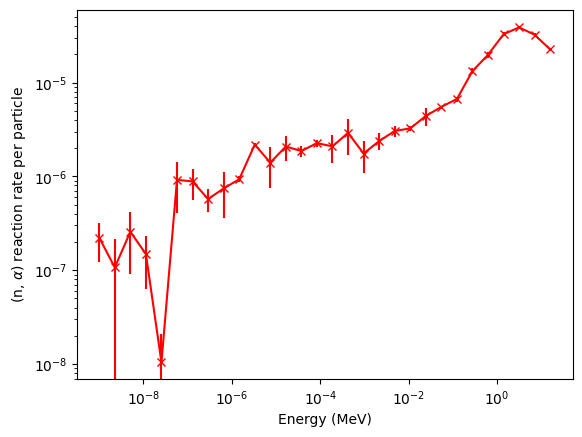

In [13]:
norm_counts = np.concatenate(nalpha_mean).tolist()
#divide by the bin widths ..
count_std = np.concatenate(nalpha_std).tolist()
print(norm_counts)

plt.errorbar(energies/10**6,norm_counts,yerr=count_std, color='r', marker='x')
plt.ylabel(r'(n, $\alpha $) reaction rate per particle')
plt.xlabel("Energy (MeV)")
plt.xscale('log')
plt.yscale('log')
plt.show()

